In [1]:
#Import librairies

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
import tkinter as tk
from tkinter import filedialog
import pathlib
import glob
from zipfile import ZipFile
import torch.utils.data
import torch.nn.functional as F
from torchvision import transforms
from torch.nn import DataParallel
from datetime import datetime
from torch.optim.lr_scheduler import MultiStepLR

ImportError: cannot import name 'builder' from 'google.protobuf.internal' (C:\Users\messe\anaconda3\lib\site-packages\google\protobuf\internal\__init__.py)

In [2]:
#https://drive.google.com/file/d/1yukjjnDSh_-IaqjsxIlevNQDornbBa2-/view?usp=share_link
!wget -q --show-progress --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1yukjjnDSh_-IaqjsxIlevNQDornbBa2-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1yukjjnDSh_-IaqjsxIlevNQDornbBa2-" -O yogaDL.rar && rm -rf /tmp/cookies.txt

yogaDL.rar          100%[===================>] 286.02M   134MB/s    in 2.1s    


In [3]:
!pip install unrar
!unrar x yogaDL.rar 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from yogaDL.rar

Creating    YOGA                                                      OK
Creating    YOGA/content                                              OK
Creating    YOGA/content/cleaned                                      OK
Creating    YOGA/content/cleaned/DATASET                              OK
Creating    YOGA/content/cleaned/DATASET/TEST                         OK
Creating    YOGA/content/cleaned/DATASET/TEST/downdog                 OK
Extracting  YOGA/content/cleaned/DATASET/TEST/downdog/00000000.jpg         0%  OK 
Extracting  YOGA/content/cleaned/DATASET/TEST/downdog/00000001.JPG         0%  OK 
Extracting  YOGA/content/cleaned/DATASET/TEST/downdog/00000002.jpg         0%  OK 
Extracting  YOGA/content/cleaned/DATASET/TEST/downdog/00000003.jpg         0%

In [4]:
# Define image directory
data_dir = "/content/YOGA/content/cleaned/DATASET/TRAIN"
data_dir = pathlib.Path(data_dir)
test_dir= "/content/YOGA/content/cleaned/DATASET/TEST"
test_dir= pathlib.Path(test_dir)

In [5]:
#set the hyper parameters
batch_size = 16
img_height = 224
img_width = 224

In [6]:
from PIL import Image
import os
import os
import cv2


# Parcourir les sous-dossiers de data_dir
for subdir, _, files in os.walk(data_dir):
    # Parcourir les fichiers dans chaque sous-dossier
    for file in files:
        # Vérifier si le fichier est une image
        if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
            # Lire l'image avec OpenCV
            img_path = os.path.join(subdir, file)
            img = cv2.imread(img_path)
            # Modifier l'extension du fichier pour jpeg
            new_img_path = os.path.splitext(img_path)[0] + ".jpeg"

            # Écrire l'image convertie en format JPEG
            cv2.imwrite(new_img_path, img, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

            # Supprimer l'image d'origine
            os.remove(img_path)


In [7]:
train_image = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    batch_size=batch_size,
    image_size=(img_height,img_width),
    shuffle=True,
    seed=123,
    validation_split=0.3,
    subset='training'
)

Found 1075 files belonging to 5 classes.
Using 753 files for training.


In [8]:
class_names = train_image.class_names
print(class_names)

['downdog', 'goddess', 'plank', 'tree', 'warrior2']


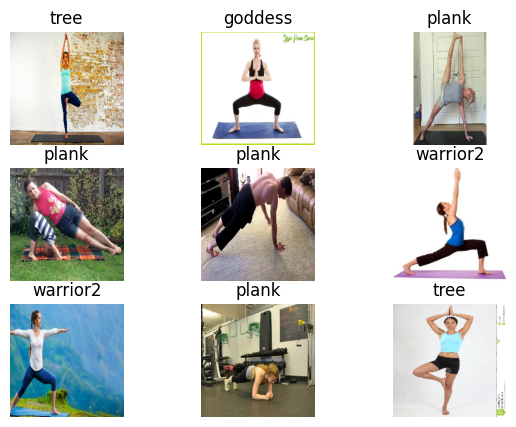

In [9]:
# Display sample images
plt.figure(figsize=(7,5))
for images, labels in train_image.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [10]:
#Data augmentation
import os
import cv2
import numpy as np
import shutil

# Liste des transformations à appliquer aux images
# Vous pouvez ajouter / supprimer des transformations selon vos besoins
transformations = {
    "rotate": lambda img: cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE),
    #"flip_h": lambda img: cv2.flip(img, 0),
    "flip_v": lambda img: cv2.flip(img, 1),
    #"blur": lambda img: cv2.GaussianBlur(img, (5, 5), 0),
    #"brightness": lambda img: cv2.convertScaleAbs(img, alpha=1.2, beta=0),
   "contrast": lambda img: cv2.convertScaleAbs(img, alpha=1.0, beta=50),
}

# Parcourir chaque dossier de train dataset pour les classes principales
for root, dirs, files in os.walk(data_dir):
    
    # Si le dossier actuel n'est pas une classe principale, ignorer
    if os.path.basename(root) not in ['tree', 'goddess', 'warrior2', 'plank', 'downdog']:
        continue
    
    # Parcourir chaque fichier image dans le dossier de classe principale
    for file_name in os.listdir(root):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            
            # Chemin vers l'image dans le dossier de classe principale
            img_file = os.path.join(root, file_name)
            
            # Charger l'image à partir du fichier
            img = cv2.imread(img_file)
            
            # Appliquer chaque transformation à l'image et enregistrer l'image augmentée
            for name, transform in transformations.items():
                aug_img = transform(img)
                aug_img_file =  os.path.join(root, f"{file_name[:-4]}_{name}_augmented.jpg")
                cv2.imwrite(aug_img_file, aug_img)

In [11]:
#create train and validation set
train_data = tf.keras.preprocessing.image_dataset_from_directory(
   data_dir, validation_split = 0.3, subset = "training", seed = 123,
    image_size = (img_height,img_width), batch_size = batch_size)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split = 0.2, subset = "validation", seed = 123,
    image_size = (img_height,img_width), batch_size = batch_size)


Found 4300 files belonging to 5 classes.
Using 3010 files for training.
Found 4300 files belonging to 5 classes.
Using 860 files for validation.


In [37]:
#test set
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    seed=1
)

# Extraire les noms de fichiers pour chaque échantillon de test
test_filenames = test_ds.file_paths
test_labels = []
for batch_images, batch_labels in test_ds:
    test_labels.extend(batch_labels.numpy())

test_labels = np.array(test_labels)



Found 466 files belonging to 5 classes.


In [13]:
train_transform = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224,224),
    #tf.keras.layers.experimental.preprocessing.RandomCrop(INPUT_SIZE),
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255),
    tf.keras.layers.experimental.preprocessing.Normalization(mean=[0.485, 0.456, 0.406],
                                                             variance=[0.229, 0.224, 0.225])
])

In [14]:
train_ds = train_data.map(lambda x, y: (train_transform(x), y))
val_ds= val_data.map(lambda x, y: (train_transform(x), y))

Modeling

In [15]:
# Model
from keras import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import load_model
# Callbacks 
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(5, activation='softmax')
])

In [17]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer = optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics = ['accuracy'])


In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 128)      

In [19]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [20]:
mymodel = model.fit(train_ds, validation_data = val_ds, epochs = 30) #training the model

Epoch 1/30


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


189/189 [==============================] - ETA: 0s - loss: 1.6363 - accuracy: 0.2339

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


189/189 [==============================] - 51s 202ms/step - loss: 1.6363 - accuracy: 0.2339 - val_loss: 1.5360 - val_accuracy: 0.3349
Epoch 2/30
189/189 [==============================] - 37s 190ms/step - loss: 1.4362 - accuracy: 0.4100 - val_loss: 1.3414 - val_accuracy: 0.4547
Epoch 3/30
189/189 [==============================] - 43s 226ms/step - loss: 1.1732 - accuracy: 0.5382 - val_loss: 0.9934 - val_accuracy: 0.6116
Epoch 4/30
189/189 [==============================] - 41s 212ms/step - loss: 0.9477 - accuracy: 0.6302 - val_loss: 0.7797 - val_accuracy: 0.7128
Epoch 5/30
189/189 [==============================] - 48s 251ms/step - loss: 0.7764 - accuracy: 0.7093 - val_loss: 0.6810 - val_accuracy: 0.7512
Epoch 6/30
189/189 [==============================] - 43s 223ms/step - loss: 0.6612 - accuracy: 0.7605 - val_loss: 0.6462 - val_accuracy: 0.7628
Epoch 7/30
189/189 [==============================] - 47s 244ms/step - loss: 0.5710 - accuracy: 0.8043 - val_loss: 0.5442 - val_accuracy: 0.8

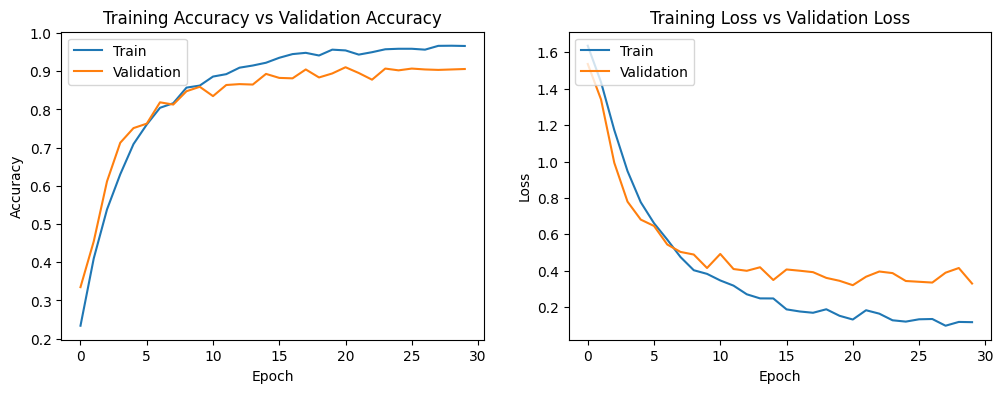

In [21]:
fig , ax = plt.subplots(1,2)
train_acc = mymodel.history['accuracy']
train_loss = mymodel.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(mymodel.history['accuracy'])
ax[0].plot(mymodel.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(mymodel.history['loss'])
ax[1].plot(mymodel.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [22]:
train_loss, train_acc = model.evaluate(train_ds)
test_loss, test_acc   = model.evaluate(val_ds)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

54/54 [==============================] - 7s 125ms/step - loss: 0.3732 - accuracy: 0.9035
final train accuracy = 99.53 , validation accuracy = 90.35


In [49]:
results = model.evaluate(test_image, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 33.20644
Test Accuracy: 90.56%


In [53]:
#!pip install h5py
model.save('yoga_pose.h5')

In [46]:
# Définir le dictionnaire de correspondance
label_map = {0: "downdog", 1: "goddess", 2:"plank", 3:"tree" ,4:"warrior2"}

# Obtenir les prédictions du modèle
# Predict the label of the test_images
pred = model.predict(test_image)
pred = np.argmax(pred,axis=1)

# Mapper les prédictions aux noms de classe correspondants
predicted_labels = [label_map[prediction.argmax()] for prediction in pred]


# Display the result
print(f'The first 5 predictions: {pred[:5]}')

30/30 [==============================] - 8s 153ms/step
The first 5 predictions: [3 0 4 4 2]


In [56]:
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
test_label_indices = np.argmax(test_labels, axis=1)
test_labels = list(test_label_indices)
y_test = test_labels
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.16      0.16      0.16        97
           1       0.17      0.13      0.15        77
           2       0.27      0.27      0.27       114
           3       0.15      0.16      0.16        69
           4       0.26      0.28      0.27       109

    accuracy                           0.21       466
   macro avg       0.20      0.20      0.20       466
weighted avg       0.21      0.21      0.21       466



In [57]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
0,0.160000,0.164948,0.162437,97.000000
1,0.172414,0.129870,0.148148,77.000000
2,0.269565,0.271930,0.270742,114.000000
3,0.152778,0.159420,0.156028,69.000000
4,0.256198,0.284404,0.269565,109.000000
accuracy,0.212446,0.212446,0.212446,0.212446
macro avg,0.202191,0.202114,0.201384,466.000000
weighted avg,0.210287,0.212446,0.210680,466.000000


AttributeError: ignored

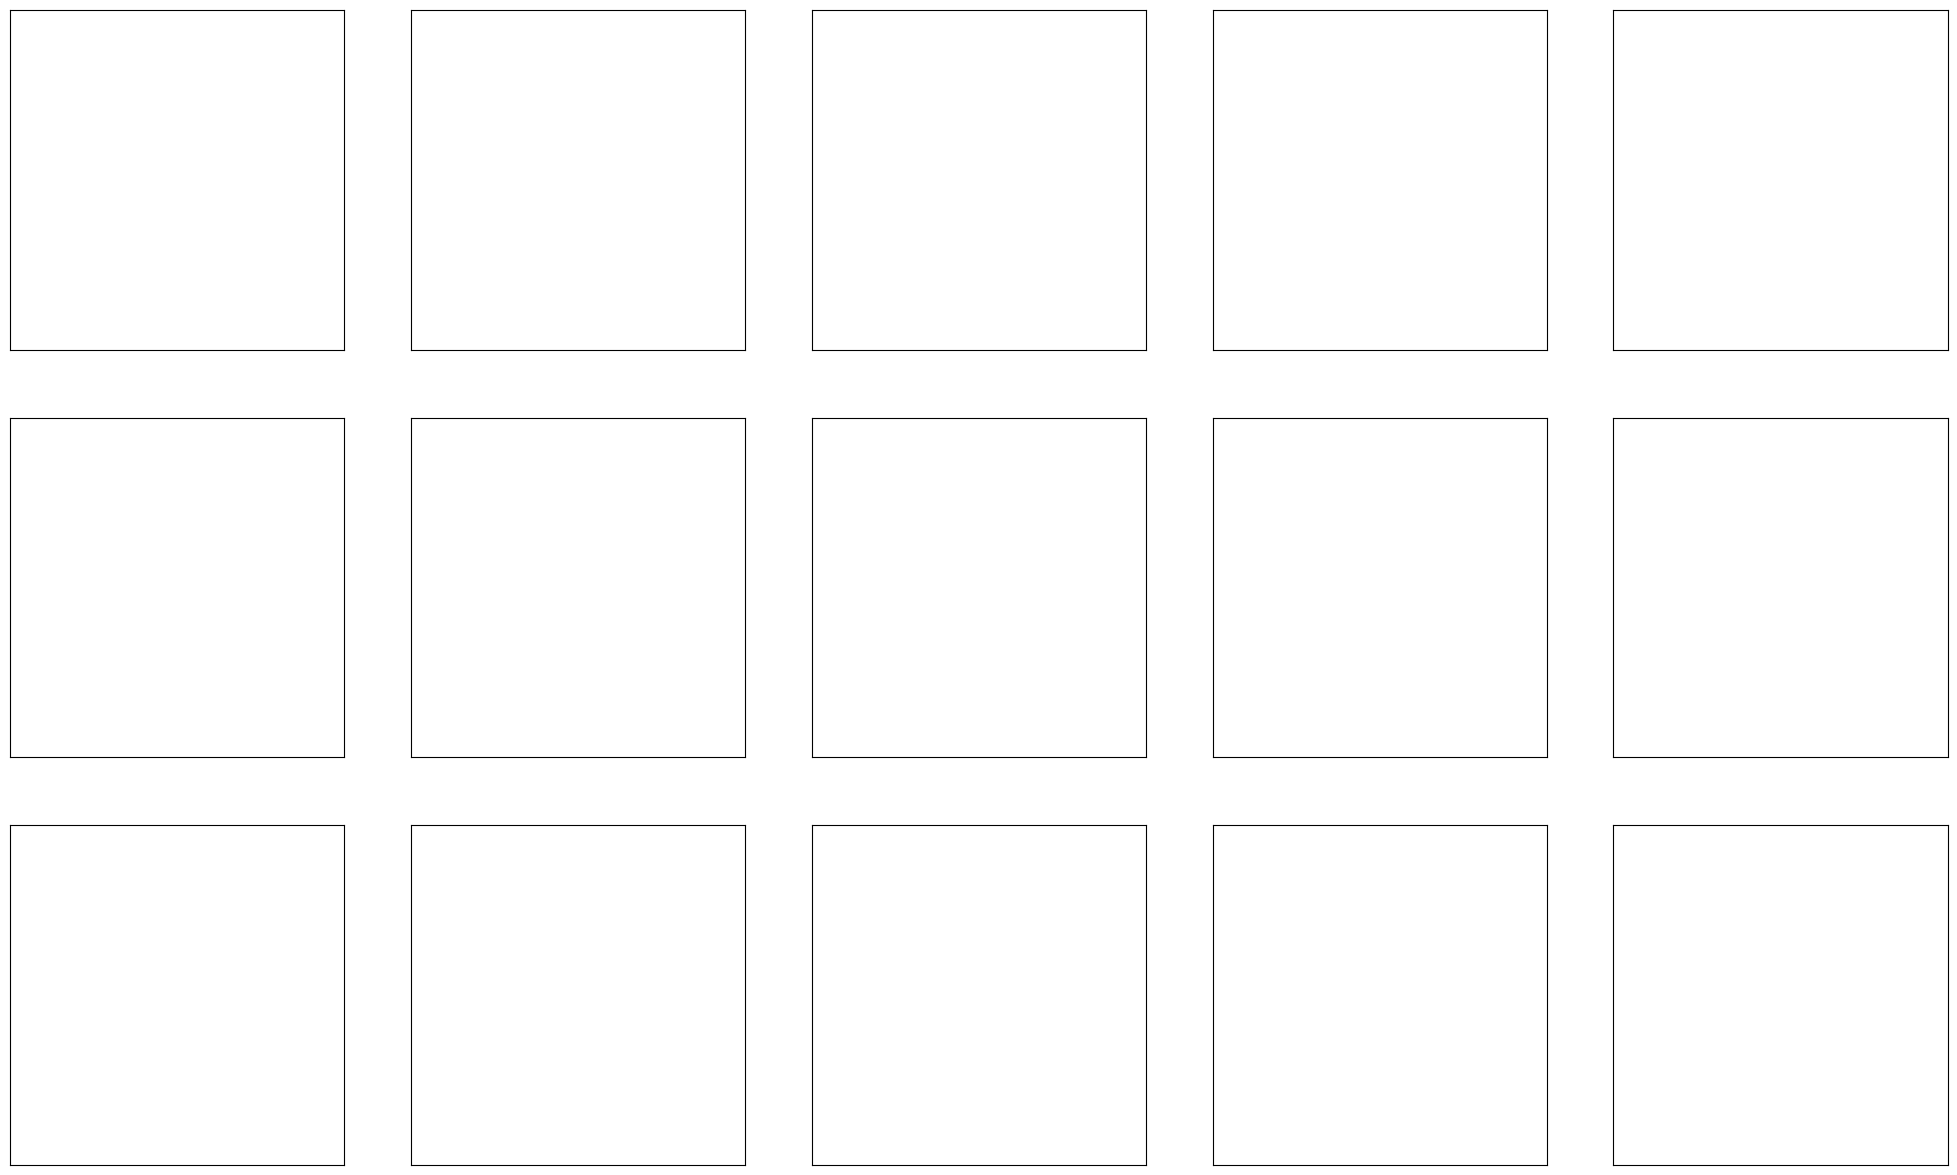

In [50]:
  # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepaths.iloc[random_index[i]]))
    if test_df.Labels.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Labels.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
y_test = list(test_df.Labels)
print(classification_report(y_test, pred))

ValueError: ignored